In [1]:
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as py
%matplotlib inline

# Get Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv")

# Preparing the dataset

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [5]:
df = df[["ram", "storage", "screen", "final_price"]]

# EDA

In [6]:
df.columns

Index(['ram', 'storage', 'screen', 'final_price'], dtype='object')

## Final Price

<AxesSubplot:>

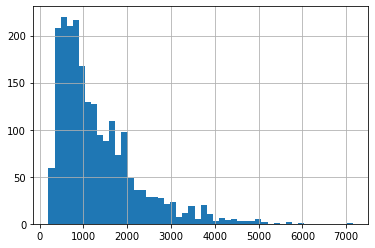

In [7]:
df["final_price"].hist(bins=50)

<AxesSubplot:ylabel='Density'>

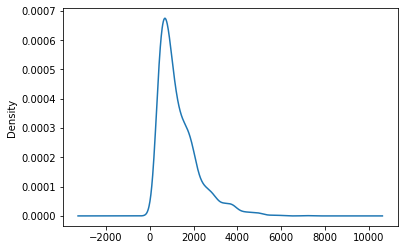

In [8]:
df["final_price"].plot.density()

# Question 1

In [9]:
df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## screen has missing values

# Question 2

In [10]:
ram_median = df["ram"].median()
ram_median

16.0

## 16 is the mean for ram

# Test, Train, validate split

In [11]:
# from sklearn.model_selection import train_test_split

In [12]:
def train_test_split(df, test_size, val_size, random_state):
    n = len(df)
    n_val = int(val_size * n)
    n_test = int(test_size * n)
    n_train = n - n_val - n_test
    # create an index same length as the df index
    idx = np.arange(n)
    # Shuffle the index
    np.random.seed(random_state)
    np.random.shuffle(idx)
    # Split index in proportion
    idx_val = idx[ : n_val]
    idx_test = idx[n_val: n_val + n_test]
    idx_train = idx[n_val + n_test: ]
    # Split the dataset
    df_val = df.iloc[idx_val]
    df_test = df.iloc[idx_test]
    df_train = df.iloc[idx_train]
    # reset index
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    return df_train, df_test, df_val

In [13]:
df_train, df_test, df_val = train_test_split(df, test_size=0.2, val_size=0.2, random_state=42)

In [14]:
y_test = df_test["final_price"].values
y_train = df_train["final_price"].values
y_val = df_val["final_price"].values

del df_val["final_price"]
del df_test["final_price"]
del df_train["final_price"]

# Question 3

In [15]:
def mean_squared_error(y, y_pred):
    sq_err = (y - y_pred) ** 2
    rmse = sq_err.mean() ** 0.5
    return rmse

## Calculate mean

In [16]:
screen_mean = df_train["screen"].mean()
fill_values = [0, screen_mean]
screen_mean

15.180974477958237

## Linear Regression function

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    XTy = X.T.dot(y)
    w_full = XTX_inv.dot(XTy)
    w_0 = w_full[0].item(0)
    w = w_full[1:]
    return w_0, w

## Fit Linear regression for different values without regularization

In [18]:
for val in fill_values:
    # Replace nan in Training set with fill value
    df_filled = df_train.fillna(val)
    X_train = df_filled.values

    # Replace nan in validation set with fill value
    df_filled_val = df_val.fillna(val)
    X_val = df_filled_val.values

    # Create model
    w0, w = train_linear_regression(X_train, y_train)

    # Predict
    y_predict = w0 + X_val.dot(w)
    
    rmse = mean_squared_error(y_val, y_predict)
    print(f"For fillvalue = {val}, rmse is {round(rmse, 2)}")

For fillvalue = 0, rmse is 624.88
For fillvalue = 15.180974477958237, rmse is 625.53


## 0 is better

# Question 4

## Regualarized Linear Regression

In [19]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0]) # regularization
    
    XTX_inv = np.linalg.inv(XTX)
    XTy = X.T.dot(y)
    w_full = XTX_inv.dot(XTy)
    w_0 = w_full[0].item(0)
    w = w_full[1:]
    return w_0, w

## Fit for different values of r

In [20]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
# Replace nan in Training set with fill value
df_filled = df_train.fillna(0)
X_train = df_filled.values

# Replace nan in validation set with fill value
df_filled_val = df_val.fillna(0)
X_val = df_filled_val.values

for r in r_values:
    # Create model
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    # Predict
    y_predict = w0 + X_val.dot(w)
    
    rmse = mean_squared_error(y_val, y_predict)
    print(f"For r = {r}, rmse is {round(rmse, 4)}")

For r = 0, rmse is 624.8785
For r = 0.01, rmse is 624.8786
For r = 0.1, rmse is 624.8806
For r = 1, rmse is 624.9171
For r = 5, rmse is 625.2341
For r = 10, rmse is 625.6367
For r = 100, rmse is 627.2698


## 0 gives best RMSE

# Question 5

## Split data set

In [21]:
def split_data(random_seed):
    df_train, df_test, df_val = train_test_split(df, test_size=0.2, val_size=0.2, random_state=random_seed)
    y_test = df_test["final_price"].values
    y_train = df_train["final_price"].values
    y_val = df_val["final_price"].values
    
    del df_val["final_price"]
    del df_test["final_price"]
    del df_train["final_price"]

    return df_test, df_train, df_val, y_test, y_train, y_val

## Compute scores for all seeds

In [22]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_scores = []

for seed in seeds:
    df_test, df_train, df_val, y_test, y_train, y_val = split_data(seed)
    # Replace nan in Training set with 0
    df_filled = df_train.fillna(0)
    X_train = df_filled.values

    # Replace nan in validation set with 0
    df_filled_val = df_val.fillna(0)
    X_val = df_filled_val.values

    # Create model
    w0, w = train_linear_regression(X_train, y_train)

    # Predict
    y_predict = w0 + X_val.dot(w)
    
    rmse = mean_squared_error(y_val, y_predict)
    rmse_scores.append(rmse)
    print(f"For seed = {seed}, rmse is {round(rmse, 2)}")

For seed = 0, rmse is 600.95
For seed = 1, rmse is 549.62
For seed = 2, rmse is 625.8
For seed = 3, rmse is 579.72
For seed = 4, rmse is 567.07
For seed = 5, rmse is 594.77
For seed = 6, rmse is 599.98
For seed = 7, rmse is 612.1
For seed = 8, rmse is 553.12
For seed = 9, rmse is 540.12


## Compute std dev

In [23]:
scores_array = np.array(rmse_scores)
std_dev = scores_array.std()
round(std_dev, 3)

27.449

## 29.176 is the std

# Question 6

In [24]:
df_test, df_train, df_val, y_test, y_train, y_val = split_data(9)
# Combine train and validation
df_full = df_train.append(df_val)
y_full = np.concatenate([y_train, y_val])

# Replace nan with 0 in training set
df_filled_full = df_full.fillna(0)
X_full = df_filled_full.values

# Replace nan with 0 in test set
df_filled_test = df_test.fillna(0)
X_test = df_filled_test.values

# Create model
w0, w = train_linear_regression_reg(X_full, y_full, r=0.001)



# Predict
y_predict = w0 + X_test.dot(w)

rmse = mean_squared_error(y_test, y_predict)
print(f"Rmse is {round(rmse, 2)}")

Rmse is 674.24


## 628.60 is the RMSE